In [1]:
import numpy as np
from numpy.random import randn

from scipy.special import gamma as gfunc
from scipy.special import airy
from scipy.special import ai_zeros
from scipy.interpolate import *
from scipy.fftpack import fft2, ifft2, fftshift, fft, ifft
from scipy.ndimage import map_coordinates, filters
from scipy.signal import convolve2d, correlate2d, correlate, find_peaks, peak_widths
from scipy.stats import gaussian_kde
from scipy.spatial.distance import *
from scipy.interpolate import *

from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
plt.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'
from IPython.display import Video

from RayTrace3D_Utilities import *

import sympy as sym
from sympy.printing.pycode import NumPyPrinter
from sympy.printing import ccode
from sympy import lambdify, Sum

import multiprocessing
from numba import jit
import builtins as bt
import math
from shapely import geometry

In [2]:
# Define relevant constants
c = 2.998e10 #speed of light
pctocm = 3.0856e18 #1 pc in cm
GHz = 1e9 #central frequency
re = 2.8179e-13 #electron radius
kpc = 1e3 # in units of pc
autocm = 1.4960e13 #1 AU in cm
pi = np.pi

# Define starting coordinates on source plane (x,y) in dimensionless coordinates (u_x, u_y)
# where u_x = (x / a_x) and a_x is the characteristic length scale (same goes for u_y).
# This is done using Sympy
u_x, u_y = sym.symbols('u_x u_y')
A, B = 1.5e-2, 5

#Use Sympy to find derivatives of the potential
N, j, theta, phi, sigma = sym.symbols('N j theta phi sigma') #name variables

# Define various lens geometries

gaussrand = sigma * sym.sqrt(2/N) * sym.Sum(sym.cos(u_y*sym.cos(sym.Indexed(theta, j)) + \
                            u_x*sym.sin(sym.Indexed(theta, j)) + sym.Indexed(phi, j)), (j, 1, N))
#gaussrand = 2 * sym.sqrt(2) * sym.cos(u_y*sym.cos(0.25*np.pi) + u_x*sym.sin(0.25*np.pi) + 2*np.pi)
gauss = sym.exp(-u_x**2-u_y**2) #gaussian
ring = 2.7182*(u_x**2 + u_y**2)*gauss #ring
rectgauss = sym.exp(-u_x**4-u_y**4)
stgauss = gauss*(1. - A*(sym.sin(B*(u_x))+sym.sin(B*(u_y - 2*pi*0.3)))) #rectangular gaussian
asymgauss = sym.exp(-u_x**2-u_y**4) #asymmetrical gaussian
supergauss2 = sym.exp(-(u_x**2+u_y**2)**2) #gaussian squared
supergauss3 = sym.exp(-(u_x**2+u_y**2)**3) #gaussian cubed
superlorentz = 1./((u_x**2 + u_y**2)**2+1.) #lorentzian with width (gamma) of 2

# Define preferred lens geometry (use gauss as test case)
lensfunc = gaussrand

# Differentiate the lens equation to 1st, 2nd, and 3rd order using Sympy
#lensg = np.array([sym.diff(lensf, u_x), sym.diff(lensf, u_y)])
lensg = np.array([sym.diff(lensfunc, u_x), sym.diff(lensfunc, u_y)])
lensh = np.array([sym.diff(lensfunc, u_x, u_x), sym.diff(lensfunc, u_y, u_y), sym.diff(lensfunc, u_x, u_y)])
lensgh = np.array([sym.diff(lensfunc, u_x, u_x, u_x), \
                sym.diff(lensfunc, u_x, u_x, u_y), \
                   sym.diff(lensfunc, u_x, u_y, u_y), \
                       sym.diff(lensfunc, u_y, u_y, u_y)])

# Use Sympy to turn the lens equations into Numpy functions using Sympy
lensfun = sym.lambdify([u_x, u_y], lensfunc, 'numpy')
lensg = sym.lambdify([u_x, u_y], lensg, 'numpy')
lensh = sym.lambdify([u_x, u_y], lensh, 'numpy')
lensgh = sym.lambdify([u_x, u_y], lensgh, 'numpy')

In [3]:
#Gaussian screen functions & derivatives

scrfun = lambda u_x, u_y, theta, phi, N, sigma : \
        np.sqrt(2)*sigma*np.sqrt(1/N)*bt.sum(np.cos(u_x*np.sin(theta[j]) + \
                u_y*np.cos(theta[j]) + phi[j]) for j in range(1, N-1))
scrgx = lambda u_x, u_y, theta, phi, N, sigma : \
        np.sqrt(2)*sigma*np.sqrt(1/N)*bt.sum(-np.sin(u_x*np.sin(theta[j]) + \
                u_y*np.cos(theta[j]) + phi[j])*np.sin(theta[j]) for j in range(1, N-1))
scrgy = lambda u_x, u_y, theta, phi, N, sigma : \
        np.sqrt(2)*sigma*np.sqrt(1/N)*bt.sum(-np.sin(u_x*np.sin(theta[j]) + \
                u_y*np.cos(theta[j]) + phi[j])*np.cos(theta[j]) for j in range(1, N-1))
scrgxx = lambda u_x, u_y, theta, phi, N, sigma : \
        -np.sqrt(2)*sigma*np.sqrt(1/N)*bt.sum(np.sin(theta[j])**2*np.cos(u_x*np.sin(theta[j]) + \
                u_y*np.cos(theta[j]) + phi[j]) for j in range(1, N-1))
scrgyy = lambda u_x, u_y, theta, phi, N, sigma : \
        -np.sqrt(2)*sigma*np.sqrt(1/N)*bt.sum(np.cos(u_x*np.sin(theta[j]) + u_y*np.cos(theta[j]) + \
                phi[j])*np.cos(theta[j])**2  for j in range(1, N-1))
scrgxy = lambda u_x, u_y, theta, phi, N, sigma : \
        -np.sqrt(2)*sigma*np.sqrt(1/N)*bt.sum(np.sin(theta[j])*np.cos(u_x*np.sin(theta[j]) + \
                u_y*np.cos(theta[j]) + phi[j])*np.cos(theta[j]) for j in range(1, N-1))
scrgxxx = lambda u_x, u_y, theta, phi, N, sigma : \
        np.sqrt(2)*sigma*np.sqrt(1/N)*bt.sum(np.sin(u_x*np.sin(theta[j]) + u_y*np.cos(theta[j]) + \
            phi[j])*np.sin(theta[j])**3 for j in range(1, N-1))
scrgxxy = lambda u_x, u_y, theta, phi, N, sigma : \
        np.sqrt(2)*sigma*np.sqrt(1/N)*bt.sum(np.sin(u_x*np.sin(theta[j]) + u_y*np.cos(theta[j]) + \
                    phi[j])*np.sin(theta[j])**2*np.cos(theta[j]) for j in range(1, N-1))
scrgxyy = lambda u_x, u_y, theta, phi, N, sigma : \
        np.sqrt(2)*sigma*np.sqrt(1/N)*bt.sum(np.sin(u_x*np.sin(theta[j]) + u_y*np.cos(theta[j]) + \
                        phi[j])*np.sin(theta[j])*np.cos(theta[j])**2 for j in range(1, N-1))
scrgyyy = lambda u_x, u_y, theta, phi, N, sigma : \
        np.sqrt(2)*sigma*np.sqrt(1/N)*bt.sum(np.sin(u_x*np.sin(theta[j]) + u_y*np.cos(theta[j]) + \
                        phi[j])*np.cos(theta[j])**3 for j in range(1, N-1))
                                             

In [4]:
def findIntersection(p1, p2):
    v1 = p1.vertices
    v2 = p2.vertices
    poly1 = geometry.LineString(v1)
    poly2 = geometry.LineString(v2)
    intersection = poly1.intersection(poly2)
    # print(intersection)
    try:
        coo = np.ones([100, 2])*1000
        for a in range(len(intersection)):
            coo[a] = np.asarray(list(intersection[a].coords))
    except:
        try:
            coo = np.asarray(list(intersection.coords))
        except:
            pass
    coo = coo[np.nonzero(coo - 1000)]
    return coo

def mapToUprime(uvec, alp, ax, ay, rF2, lc, sigma, theta, phi, N, V=None):
    """ 
    Parameters:
        uvec : vector containing u-plane coordinates
        alp : alpha coefficient
        ax : characteristic length scale in x
        ay : characteristic length scale in y
    Returns:   
        [upx, upy] : array of coordinates in the u-plane that have been
                    mapped to coordiantes in the u'-plane
    """
    ux, uy = uvec
    
    #scr = V
    #V10 = np.gradient(V, axis = 0)
    #V01 = np.gradient(V, axis = 1)
    #V20 = np.gradient(V10, axis = 0)
    #V02 = np.gradient(V01, axis = 1)
    #V11 = np.gradient(V10, axis = 1)
    #V30 = np.gradient(V20, axis = 0)
    #V03 = np.gradient(V02, axis = 1)
    #V21 = np.gradient(V20, axis = 1)
    #V12 = np.gradient(V02, axis = 0)
 
    #upx = ux + alp*V10/ax**2
    #upy = uy + alp*V01/ay**2
    #rays = np.array([upx, upy])
 
    ## Calculate Amplitude, Field, Phase and Phase Shift
    #alp = rF2*lc
    #psi20 = V20
    #psi02 = V02
    #psi11 = V11
    #phi20 = ax**2/rF2 + lc*psi20
    #phi02 = ay**2/rF2 + lc*psi02
    #phi11 = lc*psi11
    #H = phi20*phi02 - phi11**2
    #sigma = np.sign(phi02)
    #delta = np.sign(H)
    #amp = (ax*ay/rF2)*np.abs(H)**-0.5
 
    #phase = 0.5*rF2*lc**2*((V10/ax)**2 + \
    #                    V01**2) + \
    #                    lc*V - 0.5*pi
 
    #pshift = pi*(delta + 1)*sigma*0.25
 
    ## Caustic Amplitudes
    #phi20 = ax**2/rF2 + lc*psi20
    #phi02 = ay**2/rF2 + lc*psi02
    #phi11 = lc*psi11
    #phi30 = lc*V30
    #phi21 = lc*V21
    #phi12 = lc*V12
    #phi03 = lc*V03
    #B = phi20**3*phi03 - 3*phi20**2*phi11*phi12 + 3*phi20*phi11**2*phi21 - phi11**3*phi30
    #ampcaus = ax*ay/(2*pi*rF2) * 2.**(5./6.) * pi**(1./2.) * gfunc(1./3.) * \
    #        np.abs(phi20)**0.5/(3.**(1./6.) * np.abs(B)**(1./3.))
    #field = ampcaus*np.exp(1j*(phase + pshift))
    #dynspec = np.real(np.multiply(field, np.conj(field)))
    
    
    upx = ux + alp*scrgx(ux, uy, theta, phi, N, sigma)/ax**2
    upy = uy + alp*scrgy(ux, uy, theta, phi, N, sigma)/ay**2
    rays = np.array([upx, upy])

    # Calculate Amplitude, Field, Phase and Phase Shift
    alp = rF2*lc
    psi20 = scrgxx(upx, upy, theta, phi, N, sigma)
    psi02 = scrgyy(upx, upy, theta, phi, N, sigma)
    psi11 = scrgxy(upx, upy, theta, phi, N, sigma)
    phi20 = ax**2/rF2 + lc*psi20
    phi02 = ay**2/rF2 + lc*psi02
    phi11 = lc*psi11
    H = phi20*phi02 - phi11**2
    sigma = np.sign(phi02)
    delta = np.sign(H)
    amp = (ax*ay/rF2)*np.abs(H)**-0.5

    phase = 0.5*rF2*lc**2*((scrgx(upx, upy, theta, phi, N, sigma)/ax)**2 + \
                        (scrgy(upx, upy, theta, phi, N, sigma)/ay)**2) + \
                        lc*scrfun(upx, upy, theta, phi, N, sigma) - 0.5*pi

    pshift = pi*(delta + 1)*sigma*0.25

    # Caustic Amplitudes
    phi20 = ax**2/rF2 + lc*psi20
    phi02 = ay**2/rF2 + lc*psi02
    phi11 = lc*psi11
    phi30 = lc*scrgxxx(upx, upy, theta, phi, N, sigma)
    phi21 = lc*scrgxxy(upx, upy, theta, phi, N, sigma)
    phi12 = lc*scrgxyy(upx, upy, theta, phi, N, sigma)
    phi03 = lc*scrgyyy(upx, upy, theta, phi, N, sigma)
    B = phi20**3*phi03 - 3*phi20**2*phi11*phi12 + 3*phi20*phi11**2*phi21 - phi11**3*phi30
    ampcaus = ax*ay/(2*pi*rF2) * 2.**(5./6.) * pi**(1./2.) * gfunc(1./3.) * \
            np.abs(phi20)**0.5/(3.**(1./6.) * np.abs(B)**(1./3.))

    field = ampcaus*np.exp(1j*(phase + pshift))
    dynspec = np.real(np.multiply(field, np.conj(field)))
    
    

    return rays, ampcaus, phase, field, dynspec, pshift, scr

def findRoots(rays, rx, ry):
    raysx = rays[0]
    raysy = rays[1]
    cs0 = plt.contour(rx, ry, raysx, levels = [0, np.inf], colors = 'red')
    cs1 = plt.contour(rx, ry, raysy, levels = [0, np.inf], colors = 'blue')
    c0 = cs0.collections[0]
    c1 = cs1.collections[0]
    paths0 = c0.get_paths()
    paths1 = c1.get_paths()
    roots = np.array([])
    for p0 in paths0:
        for p1 in paths1:
            root = findIntersection(p0, p1)
            if len(root) != 0:
                roots = np.append(roots, root)
    roots = np.asarray(roots).flatten().reshape(-1, 2)
    p = np.argsort(roots.T[0])
    roots_all = roots[p]
    return roots_all

In [5]:
# We are going to solve the lens equation to find the mapping between the
# u' and u plane numerically using a root finding algorithm.
# For now, however, this won't be necessary - but we'll set up the tools for later (3.2.21).
# Compute 100 zeros and values of the Airy function Ai and its derivative
# where index 1 for ai_zeros() returns the first 100 zeros of Ai’(x) and
# index 0 for airy() returns Ai'(x).
# Note for later: A caustic in which two images merge corresponds to a
# fold catastrophe, and close to a fold the field follows an Airy function pattern.
airyzeros = ai_zeros(100)[1]
airyfunc = airy(airyzeros)[0]**2/2.
airsqrenv = interp1d(airyzeros, airyfunc, kind = 'cubic', fill_value = 'extrapolate')

# Define screen paramters (Gaussian & Kolmogorov)
nscreen = 100
N = 10
# Define screen paramters (Gaussian & Kolmogorov)
sigma = 20
iscreen = 1 #which wavefront to plot
dso = 1*kpc*pctocm #distance from source to observer
dsl = 1*kpc*pctocm / nscreen #distance from source to screen
dm = 1e-3*pctocm #dispersion measure
ax, ay = 0.8*autocm, 0.8*autocm #screen width (x,y)
uxmax, uymax = 15., 15. #screen coordinates

# Frequencies
fmin, fmax = 1.*GHz, 1.1*GHz #min/max frequency
nchan = 12
freqs = np.linspace(fmin, fmax, nchan)
#print('Observation Frequency (GHz): ', (fmax+fmin)//2 * 1e-9)

# Construct u plane
npoints = 150
rx = np.linspace(-uxmax, uxmax, npoints)
ry = np.linspace(-uymax, uymax, npoints)
#rx = np.linspace(-1, 1, npoints)
#ry = np.linspace(-1, 1, npoints)
uvec = np.meshgrid(rx, ry)
ux, uy = uvec

Channel Frequency:  1000000000.0
Channel Frequency:  1009090909.0909091
Channel Frequency:  1018181818.1818181
Channel Frequency:  1027272727.2727273
Channel Frequency:  1036363636.3636364
Channel Frequency:  1045454545.4545455
Channel Frequency:  1054545454.5454545
Channel Frequency:  1063636363.6363636
Channel Frequency:  1072727272.7272727
Channel Frequency:  1081818181.8181818
Channel Frequency:  1090909090.909091
Channel Frequency:  1100000000.0


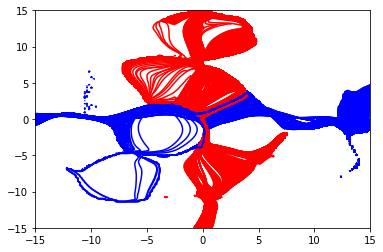

In [6]:
raypropsteps = np.zeros((nchan, nscreen, 2, npoints, npoints)) #store ray wavefront at each screen
screens = np.zeros((nscreen, npoints, npoints)) #store phases at each screen
phases = np.zeros((nchan, nscreen, npoints, npoints))
phaseshift = np.zeros((nchan, nscreen, npoints, npoints))
fields = np.zeros((nchan, nscreen, npoints, npoints), dtype = complex)
dynspecs = np.zeros((nchan, nscreen, npoints, npoints), dtype = complex)
amps = np.zeros((nchan, nscreen, npoints, npoints))
thetas = np.zeros((nscreen, N))
phis = np.zeros((nscreen, N))
roots = {}

for scr in range(nscreen):

    thetas[scr] = np.random.uniform(0,2*np.pi, N)
    phis[scr] = np.random.uniform(0, 2*np.pi, N)
    screens[scr] = scrfun(ux, uy, thetas[scr], phis[scr], N, sigma)
    V = np.zeros((npoints, npoints))
    rF2 = rFsqr(dso, dsl, freqs[0])
    rF = np.sqrt(rF2)
    #print(rF)
    AR = np.random.randint(1, 30)
    #print(AR)
    #V = Kolmogorov(npoints, npoints, dx = 0.05*rF, dy = 0.05*rF, rf = rF, psi = 0, ar = 4, alpha = 5./3., mb2 = 20., inner = 0.001*rF)
    #screens[scr] = V

for n in range(nchan):

    print('Channel Frequency: ', freqs[n])

    # Calculate coefficients for the scr equation
    rF2 = rFsqr(dso, dsl, freqs[n])#freqs[n])
    uF2x, uF2y = rF2*np.array([1./ax**2, 1./ay**2])
    lc = lensc(dm, freqs[n]) #freqs[n]) #calculate phase perturbation due to the scr
    #print('Phase Pertrubation $\phi_{0}$: ', lc)
    alp  = rF2*lc
    coeff = alp*np.array([1./ax**2, 1./ay**2])

    for scr in range(nscreen):

        if scr == 0:
            #map_ = mapToUprime(uvec, alp, ax, ay, rF2, lc, sigma, thetas[scr], phis[scr], N, screens[scr])
            map_ = mapToUprime(uvec, alp, ax, ay, rF2, lc, sigma, thetas[scr], phis[scr], N)
            raypropsteps[n][scr] = map_[0]
            amps[n][scr] = map_[1]
            phases[n][scr] = map_[2]
            fields[n][scr] = map_[3]
            dynspecs[n][scr] = map_[4]
            phaseshift[n][scr] = map_[5]
            roots[n] = {}
            roots[n][scr] = findRoots(map_[0], rx, ry)
            screens[scr] = screens[scr]

            
        else:
            #map_ = mapToUprime(raypropsteps[n][scr-1], alp, ax, ay, rF2, lc, sigma, thetas[scr], phis[scr], N, screens[scr])
            map_ = mapToUprime(raypropsteps[n][scr-1], alp, ax, ay, rF2, lc, sigma, thetas[scr], phis[scr], N)
            raypropsteps[n][scr] = map_[0]
            amps[n][scr] = map_[1]
            phases[n][scr] = map_[2]
            fields[n][scr] = map_[3]
            dynspecs[n][scr] = map_[4]
            phaseshift[n][scr] = map_[5]
            roots[n] = {}
            roots[n][scr] = findRoots(map_[0], rx, ry)
            screens[scr] = screens[scr]


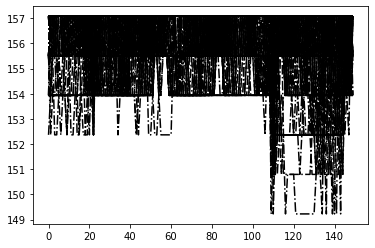

In [7]:
#CHECK PHASE DELAYS

plt.plot(phaseshift[:][0].sum(0), c = 'k', linestyle = 'dashdot')
plt.show()

Plotted Frequency (GHz):  1.0
Plotted Screen:  9
Max:  0.0


<ipython-input-23-a2c0c1c68bf3>:14: ComplexWarning: Casting complex values to real discards the imaginary part
  dynspec[s][n] = dynspecs[n][s][npoints//2, :]


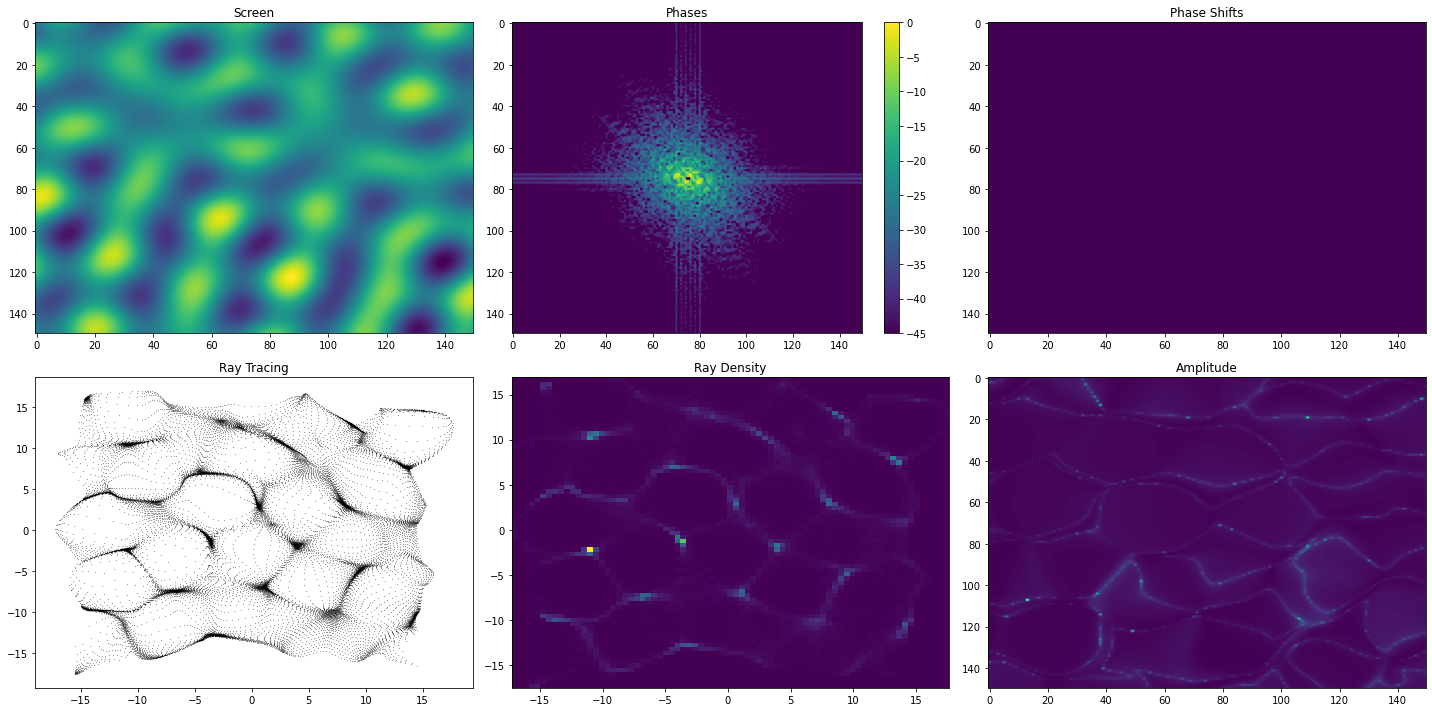

/Users/jakobfaber/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


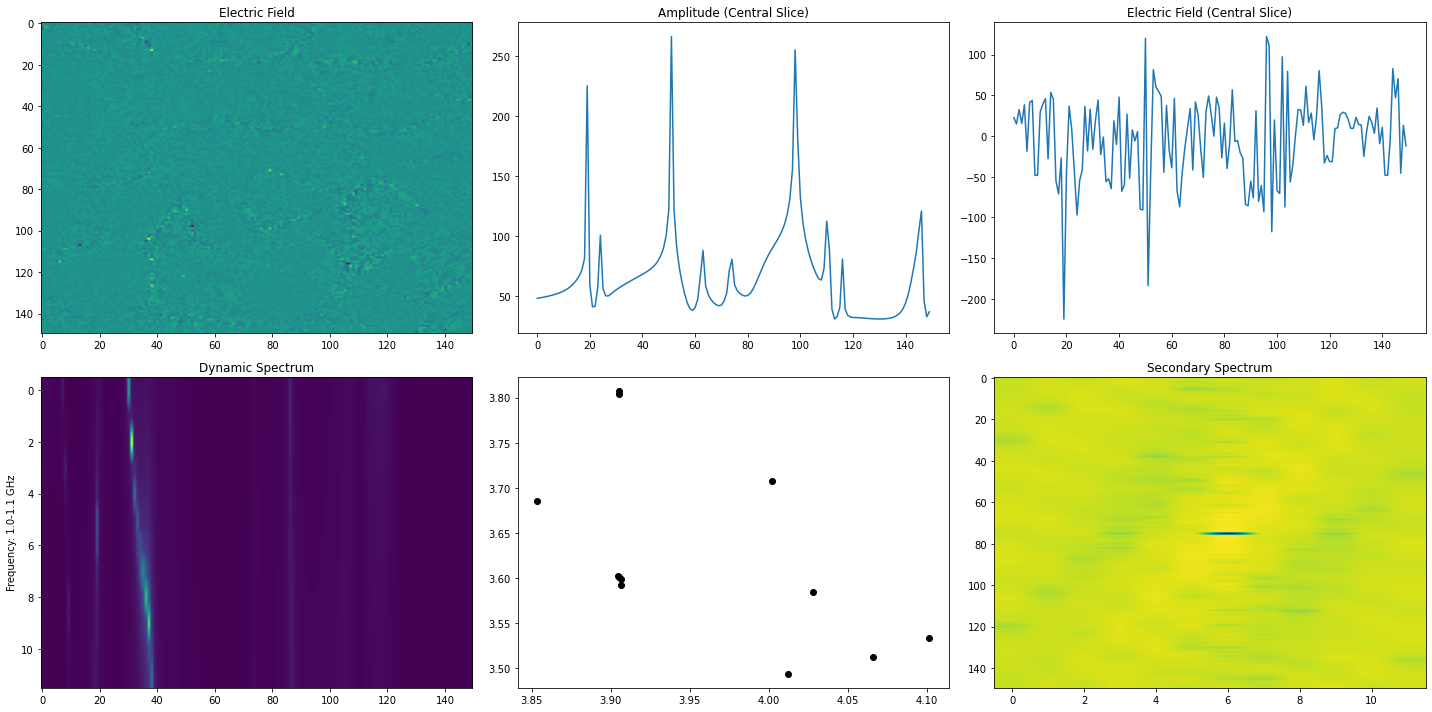

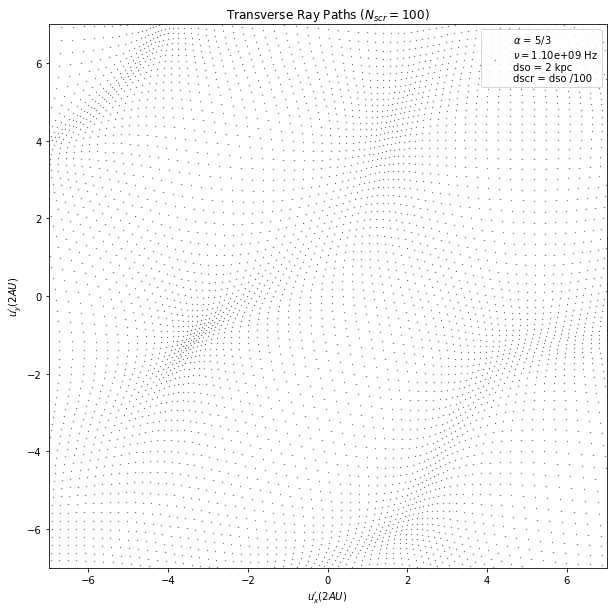

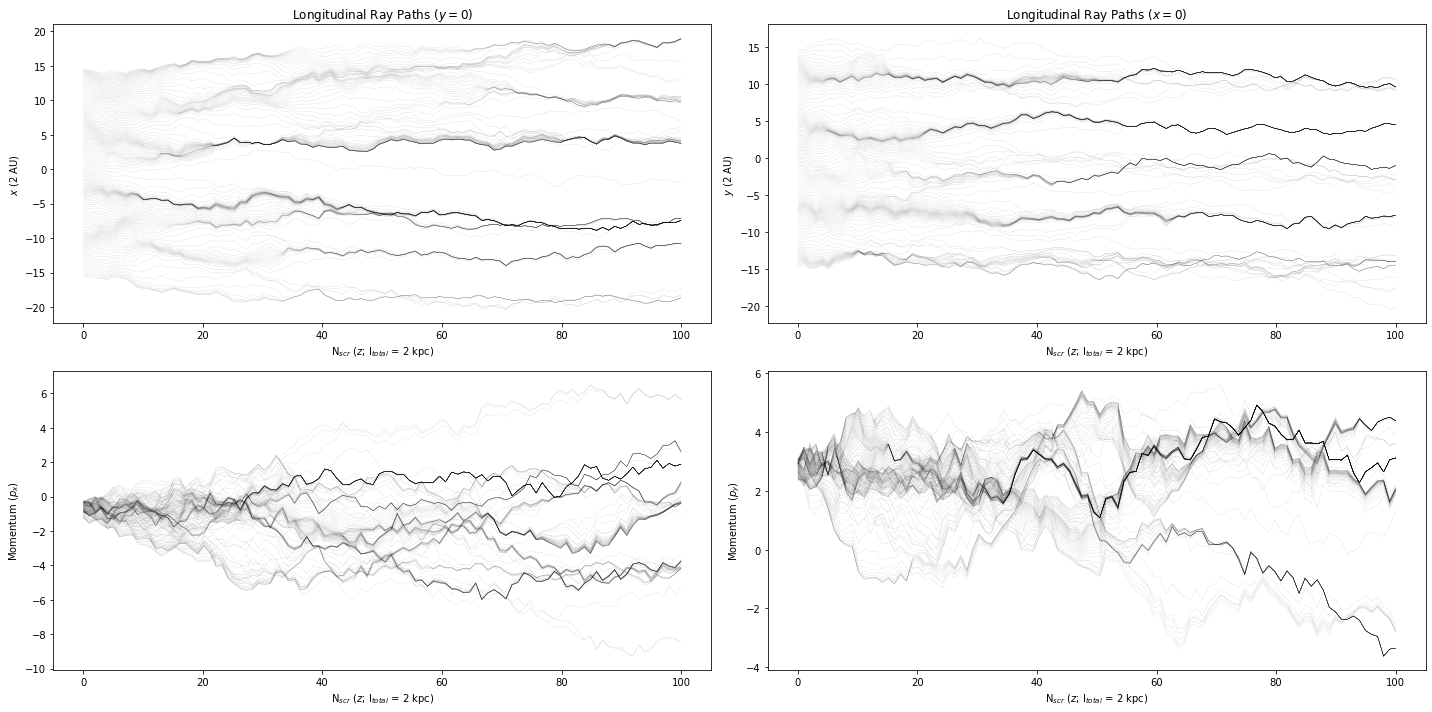

In [23]:
from matplotlib import colors 

chan = 0
print('Plotted Frequency (GHz): ', freqs[chan] * 1e-9)
screen = 9
print('Plotted Screen: ', screen)


# Construct Dynamic Spectrum
dynspec = np.zeros((nscreen, nchan, npoints))

for s in range(nscreen):
    for n in range(nchan):
        dynspec[s][n] = dynspecs[n][s][npoints//2, :]

# Construct Secondary Spectrum

secfft = np.fft.fftn((dynspec[screen])-np.mean(dynspec[screen]))
secreal = np.absolute(np.fft.fftshift(secfft))**2
secspec = 10*np.log10(secreal/np.max(secreal))

#secfft = np.fft.fftn((dynspecs[chan][screen])-np.mean(dynspecs[chan][screen]))
#secreal = np.absolute(np.fft.fftshift(secfft))**2
#secspec = 10*np.log10(secreal/np.max(secreal))

fig = plt.figure(figsize = (20, 10))

ax0 = fig.add_subplot(231)
plt.imshow(screens[screen], aspect = 'auto')
plt.title('Screen')

ax1 = fig.add_subplot(232)

allphases = np.zeros((npoints, npoints))
for s in range(nscreen):
    allphases += phases[chan][screen]
#plt.imshow(allphases, aspect = 'auto')

secfftp = np.fft.fftn((allphases)-np.mean(allphases))
secrealp = np.absolute(np.fft.fftshift(secfftp))**2
secspecp = 10*np.log10(secrealp/np.max(secrealp))


#plt.plot(secspecp[npoints//2+0:npoints//2+5, :].sum(0))#, aspect = 'auto')
#plt.plot(secspecp[npoints//2+5:npoints//2+10, :].sum(0)+50)#, aspect = 'auto')
#plt.plot(secspecp[npoints//2+10:npoints//2+15, :].sum(0)+100)#, aspect = 'auto')
#plt.plot(secspecp[npoints//2+15:npoints//2+20, :].sum(0)+150)#, aspect = 'auto')
#plt.plot(secspecp[npoints//2+20:npoints//2+25, :].sum(0)+200)#, aspect = 'auto')
plt.imshow(secspecp, aspect = 'auto', vmin = -45, vmax = 0)
plt.colorbar()
print('Max: ', np.max(secspecp))
plt.title('Phases')

ax3 = fig.add_subplot(233)

plt.imshow(phaseshift[chan][screen], aspect = 'auto')
plt.title('Phase Shifts')

ax4 = fig.add_subplot(234)

xflat = np.ndarray.flatten(np.array(raypropsteps[chan][screen][0]))
yflat = np.ndarray.flatten(np.array(raypropsteps[chan][screen][1]))
plt.scatter(xflat, yflat, c = 'k', s = 0.02)
plt.title('Ray Tracing')

ax5 = fig.add_subplot(235)

plt.hist2d(xflat, yflat, bins = npoints//2)
plt.title('Ray Density')

ax6 = fig.add_subplot(236)

plt.imshow(amps[chan][screen], aspect = 'auto')
plt.title('Amplitude')

plt.tight_layout()
plt.show()
fig.savefig('Diagnostic1_Sig' + str(sigma) + '.png')

fig1 = plt.figure(figsize = (20, 10))

ax2 = fig1.add_subplot(231)

plt.imshow(fields[chan][screen].real, aspect = 'auto')
plt.title('Electric Field')

ax3 = fig1.add_subplot(232)

plt.plot(amps[chan][screen][:, npoints//2])
plt.title('Amplitude (Central Slice)')

ax4 = fig1.add_subplot(233)

plt.plot(fields[chan][screen][:, npoints//2])
plt.title('Electric Field (Central Slice)')

ax5 = fig1.add_subplot(234)

plt.imshow(dynspec[screen], aspect = 'auto')
plt.ylabel('Frequency: ' + str(round(fmin*1e-9, 2)) + '-' + str(round(fmax*1e-9, 2)) + ' GHz')
plt.title('Dynamic Spectrum')

ax6 = fig1.add_subplot(235)
# get electric field impulse response
#p = np.fft.fft(np.multiply(dynspec[screen], np.blackman(nchan)[:, None]), 2*nchan)
#p = np.real(p*np.conj(p))  # get intensity impulse response
# shift impulse to middle of window
#pulsewin = np.transpose(np.roll(p, nchan))
#Freq = freqs/1000
#lpw = np.log10(pulsewin)
#vmax = np.max(lpw)
#vmin = np.median(lpw) - 3
#plt.imshow(lpw, aspect = 'auto', vmin = vmin, vmax = vmax)
#plt.pcolormesh(np.linspace(0, uxmax, nchan),
#              (np.arange(0, nchan, 1) - nchan/2) /
#               (2*(c/nchan)*Freq),
#               lpw[int(nchan/2):, :], vmin=vmin, vmax=vmax)
#plt.colorbar
#plt.ylabel('Delay (ns)')
#plt.xlabel('$x/r_f$')

#plt.plot(np.linspace(0, nchan, nchan),
#         -dm/(2*(c/nchan)*Freq), 'k')  # group delay=-phase delay
for i in range(nchan):
    plt.scatter(roots[i][scr].T[0], roots[i][scr].T[1], color = 'black')
    
ax7 = fig1.add_subplot(236)

plt.imshow(secspec.T, aspect = 'auto')
plt.title('Secondary Spectrum')
    
plt.tight_layout()
plt.show()
fig1.savefig('Diagnostic2_Sig' + str(sigma) + '.png')

x_dat = raypropsteps[:, :, 0, :, :]
y_dat = raypropsteps[:, :, 1, :, :]

propx = np.zeros((nscreen, (npoints*npoints)))
propy = np.zeros((nscreen, (npoints*npoints)))

for s in range(nscreen):
    propx[s] = np.ndarray.flatten(x_dat[chan][s])
    propy[s] = np.ndarray.flatten(y_dat[chan][s])


# Plot wavefront scatter plots (both singular and 4x4)

fig1 = plt.figure(figsize=(10,10))
fig1.tight_layout()
ax1 = plt.subplot(111)
ax1.set_xlim(-5, 5)
ax1.set_ylim(-5, 5)

scat = ax1.scatter(propx[0], propy[0], c = 'k', s=0.05, \
            label = r'$\alpha$ = ' + '5/3' + '\n' + r'$\nu = $' + '{:.2e}'.format(fmax) + \
            ' Hz' + '\n' + 'dso = 2 kpc' + '\n' + 'dscr = dso /' + str(nscreen))
ax1.set_title('Transverse Ray Paths ($N_{scr} = $' + str(nscreen) + ')')
ax1.set_xlabel('$u^\prime_{x} (2 AU)$')
ax1.set_ylabel('$u^\prime_{y} (2 AU)$')
ax1.set_xlim(-7, 7)
ax1.set_ylim(-7, 7)
ax1.legend(loc = 'upper right')

# Animation update function
def animationUpdate(k):
    x = propx[k]
    y = propy[k]
    scat.set_offsets(np.c_[x,y])
    return scat,

# function for creating animation
anim = FuncAnimation(fig1, animationUpdate, frames=int(nscreen-1), interval=200) #, blit=True)#, repeat_delay=3000)

# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer()
#anim.save('RayPathsTransverse_Video.mp4', writer=writer, dpi=300)

fig2 = plt.figure(figsize = (20, 10))
ax = fig2.add_subplot(221)

s = np.linspace(0, nscreen, nscreen)
for i in range(npoints):
    plt.plot(s, x_dat[chan, :, npoints//2, i], c = 'k', linewidth = 0.05)
plt.title('Longitudinal Ray Paths ($y = 0$)')
plt.ylabel('$x$ (2 AU)')
plt.xlabel('N$_{scr}$ ($z$; l$_{total}$ = 2 kpc)')
    
ax2 = fig2.add_subplot(222)
s = np.linspace(0, nscreen, nscreen)
for i in range(npoints):
    plt.plot(s, y_dat[chan, :, i, npoints//2], c = 'k', linewidth = 0.05)
plt.title('Longitudinal Ray Paths ($x = 0$)')
plt.ylabel('$y$ (2 AU)')
plt.xlabel('N$_{scr}$ ($z$; l$_{total}$ = 2 kpc)')
    
ax3 = fig2.add_subplot(223)
s = np.linspace(0, nscreen, nscreen)
for i in range(npoints):
    plt.plot(s, x_dat[chan, :, i, 0] - np.mean(x_dat[chan, :, 0, 0]), c = 'k', linewidth = 0.05)
plt.ylabel('Momentum ($p_{x}$)')
plt.xlabel('N$_{scr}$ ($z$; l$_{total}$ = 2 kpc)')

    
ax4 = fig2.add_subplot(224)
s = np.linspace(0, nscreen, nscreen)
for i in range(npoints):
    plt.plot(s, y_dat[chan, :, 0, i] - np.mean(y_dat[chan, :, 0, 0]), c = 'k', linewidth = 0.05)
plt.ylabel('Momentum ($p_{y}$)')
plt.xlabel('N$_{scr}$ ($z$; l$_{total}$ = 2 kpc)')
plt.tight_layout()
plt.show()
fig2.savefig('RayPathsLongitudinal_4x4.png')

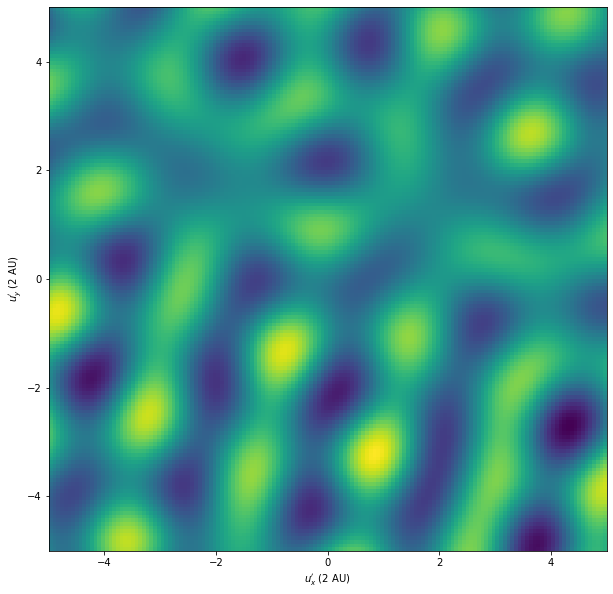

In [22]:
fig = plt.figure(figsize = (10, 10))

plt.imshow(screens[screen], extent = (-5, 5, -5, 5), aspect = 'auto')
#plt.title('Screen')
plt.xlabel('$u^\prime_{x}$ (2 AU)')
plt.ylabel('$u^\prime_{y}$ (2 AU)')

fig.savefig('GaussianScreen.png')

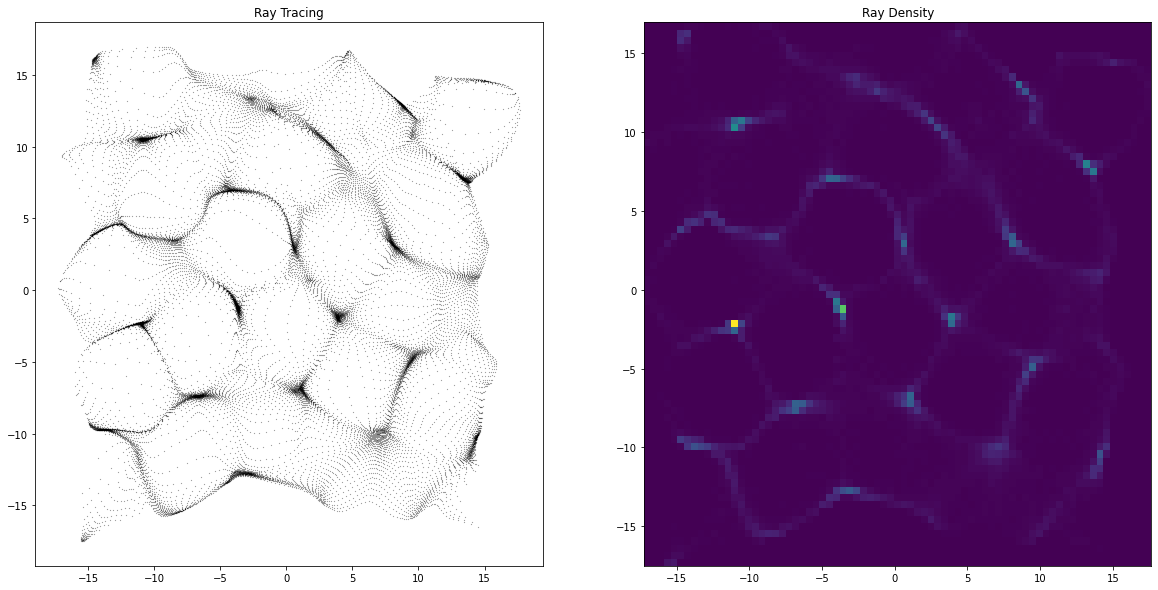

In [12]:
fig = plt.figure(figsize = (20, 10))

ax4 = fig.add_subplot(121)

xflat = np.ndarray.flatten(np.array(raypropsteps[chan][screen][0]))
yflat = np.ndarray.flatten(np.array(raypropsteps[chan][screen][1]))
plt.scatter(xflat, yflat, c = 'k', s = 0.02)
plt.title('Ray Tracing')

ax5 = fig.add_subplot(122)

plt.hist2d(xflat, yflat, bins = npoints//2)
plt.title('Ray Density')

fig.savefig('gaussrays2d.png')

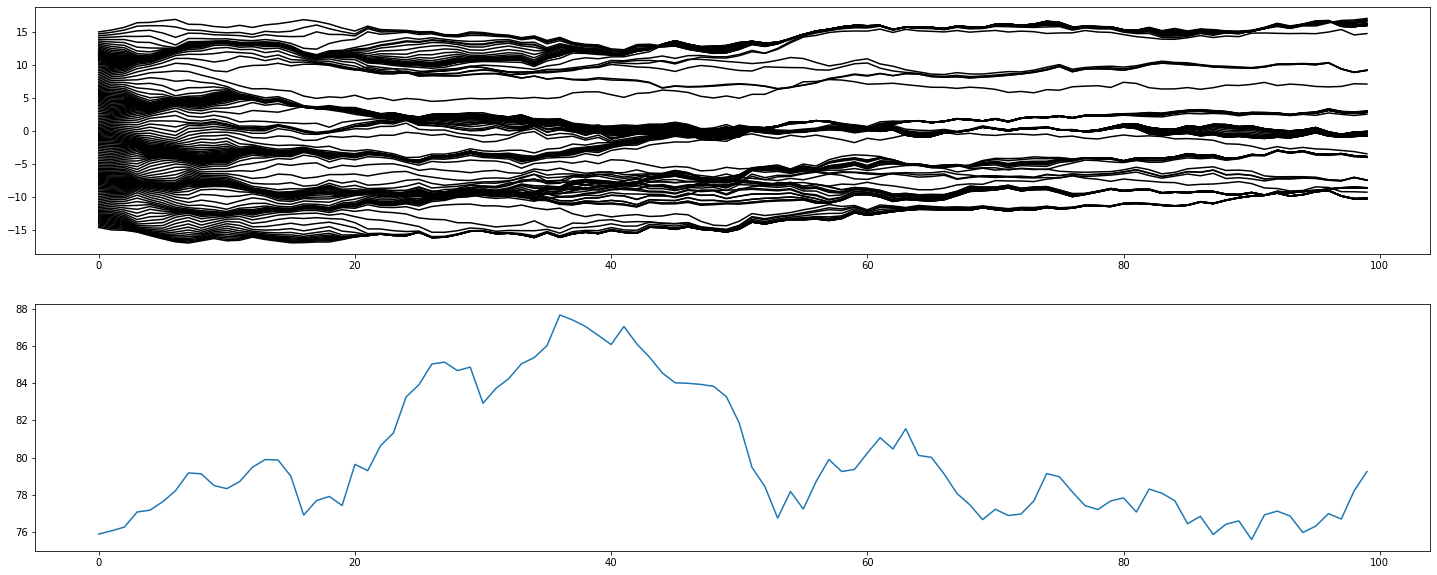

In [109]:
fig = plt.figure(figsize = (25, 10))
ax = fig.add_subplot(211)
plt.plot(x_dat[chan, :, npoints//2, :], c = 'k')
xdat = x_dat[chan, :, :, :]
var = np.zeros(nscreen)
for s in range(nscreen):
    var[s] = np.var(xdat[s])
ax1 = fig.add_subplot(212)
plt.plot(var)
plt.show()

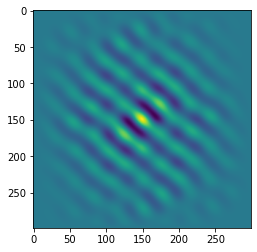

In [127]:
scorr = correlate2d(screens[screen], screens[screen])
plt.imshow(scorr)
plt.show()

# scr = 20

fig = plt.figure(figsize = (10, 10))
plt.imshow(screens[scr-1])
plt.title('Phase Screen')
plt.colorbar()
plt.tight_layout()
plt.show()

fig = plt.figure(figsize = (10, 10))
plt.scatter(raypropsteps[scr][0], raypropsteps[scr][1], c = 'k', s = 0.02)
plt.title('Ray Tracing')
plt.show()

fig = plt.figure(figsize = (10, 10))
plt.imshow(amp[scr])
plt.title('Amplitude')
plt.colorbar()
plt.tight_layout()
plt.show()

fig = plt.figure(figsize = (10, 10))
plt.imshow(phases[scr])
plt.title('Wave Phase')
plt.colorbar()
plt.tight_layout()
plt.show()

In [9]:
def gridToPixel(u, umax, gsize):
    return 0.5*gsize*(u/umax + 1.)

def lensPhase(ux, uy, lc):
    """ Return the lens phase perturbation. """
    arg = lc*lensfun(ux, uy)
    return np.exp(1j*arg)

def geoPhase(ux, uy, uF2x, uF2y):
    """ Returns the quadratic phase factor. """
    arg = ux**2/(2*uF2x) + uy**2/(2*uF2y)
    return np.exp(1j*arg)

# Field
def GOfield(uvec, rF2, lc, ax, ay):
    """ Returns the elements of the geometrical optics field: the amplitude and the phase, including the phase shift as determined by the sign of the derivatives. """
    ux, uy = uvec
    alp = rF2*lc
    psi20, psi02, psi11 = lensh(ux, uy)
    phi20 = ax**2/rF2 + lc*psi20
    phi02 = ay**2/rF2 + lc*psi02
    phi11 = lc*psi11
    sigma = np.sign(phi02)
    H = phi20*phi02 - phi11**2
    delta = np.sign(H)
    amp = (ax*ay/rF2)*np.abs(H)**-0.5
    phase = phi(uvec, rF2, lc, ax, ay)
    pshift = pi*(delta + 1)*sigma*0.25
    # return amp*np.exp(1j*(phase + pshift))
    return np.array([amp, phase, pshift])

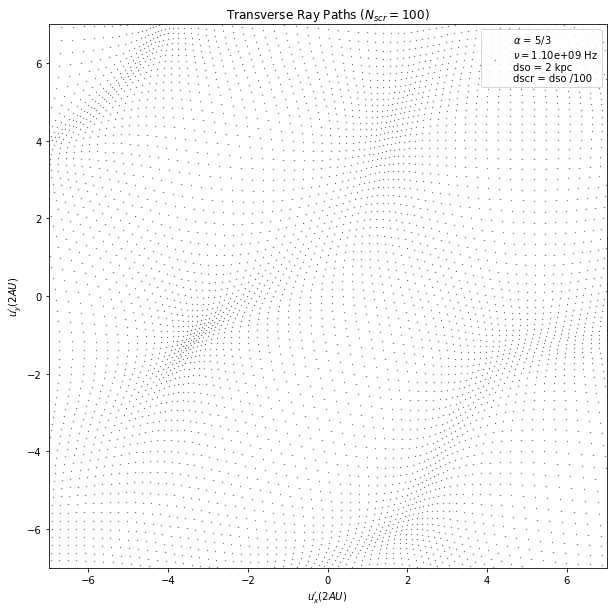

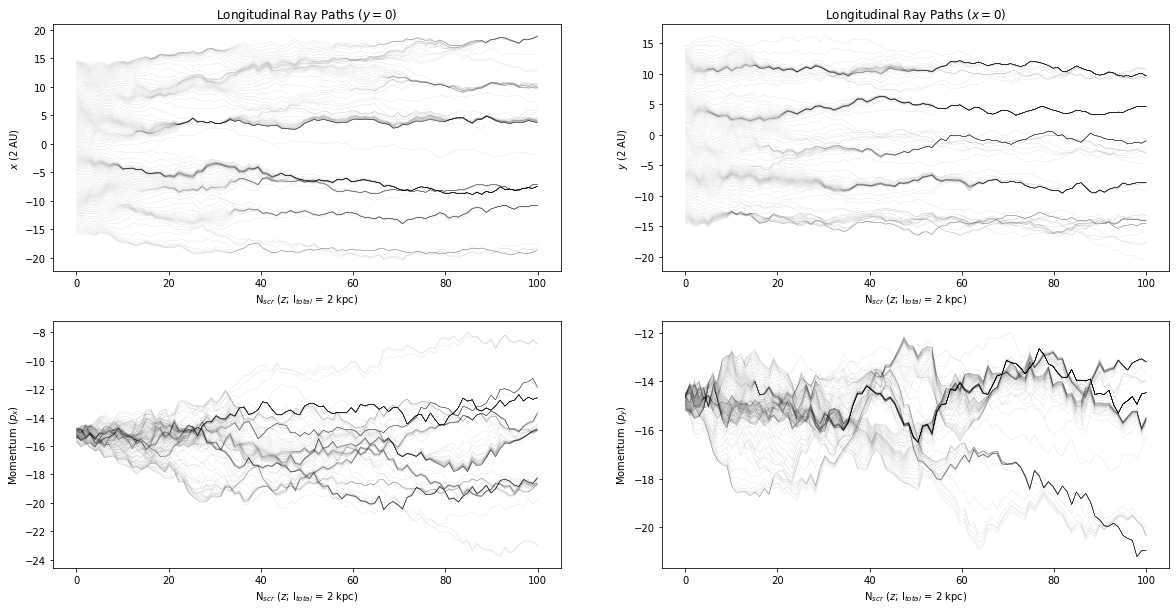

In [10]:
x_dat = raypropsteps[:, :, 0, :, :]
y_dat = raypropsteps[:, :, 1, :, :]

propx = np.zeros((nscreen, (npoints*npoints)))
propy = np.zeros((nscreen, (npoints*npoints)))

for s in range(nscreen):
    propx[s] = np.ndarray.flatten(x_dat[chan][s])
    propy[s] = np.ndarray.flatten(y_dat[chan][s])


# Plot wavefront scatter plots (both singular and 4x4)

fig1 = plt.figure(figsize=(10,10))
fig1.tight_layout()
ax1 = plt.subplot(111)
ax1.set_xlim(-5, 5)
ax1.set_ylim(-5, 5)

scat = ax1.scatter(propx[0], propy[0], c = 'k', s=0.05, \
            label = r'$\alpha$ = ' + '5/3' + '\n' + r'$\nu = $' + '{:.2e}'.format(fmax) + \
            ' Hz' + '\n' + 'dso = 2 kpc' + '\n' + 'dscr = dso /' + str(nscreen))
ax1.set_title('Transverse Ray Paths ($N_{scr} = $' + str(nscreen) + ')')
ax1.set_xlabel('$u^\prime_{x} (2 AU)$')
ax1.set_ylabel('$u^\prime_{y} (2 AU)$')
ax1.set_xlim(-7, 7)
ax1.set_ylim(-7, 7)
ax1.legend(loc = 'upper right')

# Animation update function
def animationUpdate(k):
    x = propx[k]
    y = propy[k]
    scat.set_offsets(np.c_[x,y])
    return scat,

# function for creating animation
anim = FuncAnimation(fig1, animationUpdate, frames=int(nscreen-1), interval=200) #, blit=True)#, repeat_delay=3000)

# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer()
#anim.save('RayPathsTransverse_Video.mp4', writer=writer, dpi=300)

fig2 = plt.figure(figsize = (20, 10))
fig2.tight_layout()
ax = fig2.add_subplot(221)
s = np.linspace(0, nscreen, nscreen)
for i in range(npoints):
    plt.plot(s, x_dat[chan, :, npoints//2, i], c = 'k', linewidth = 0.05)
plt.title('Longitudinal Ray Paths ($y = 0$)')
plt.ylabel('$x$ (2 AU)')
plt.xlabel('N$_{scr}$ ($z$; l$_{total}$ = 2 kpc)')
    
ax2 = fig2.add_subplot(222)
s = np.linspace(0, nscreen, nscreen)
for i in range(npoints):
    plt.plot(s, y_dat[chan, :, i, npoints//2], c = 'k', linewidth = 0.05)
plt.title('Longitudinal Ray Paths ($x = 0$)')
plt.ylabel('$y$ (2 AU)')
plt.xlabel('N$_{scr}$ ($z$; l$_{total}$ = 2 kpc)')
    
ax3 = fig2.add_subplot(223)
s = np.linspace(0, nscreen, nscreen)
for i in range(npoints):
    plt.plot(s, x_dat[chan, :, i, 0], c = 'k', linewidth = 0.05)
plt.ylabel('Momentum ($p_{x}$)')
plt.xlabel('N$_{scr}$ ($z$; l$_{total}$ = 2 kpc)')

    
ax4 = fig2.add_subplot(224)
s = np.linspace(0, nscreen, nscreen)
for i in range(npoints):
    plt.plot(s, y_dat[chan, :, 0, i], c = 'k', linewidth = 0.05)
plt.ylabel('Momentum ($p_{y}$)')
plt.xlabel('N$_{scr}$ ($z$; l$_{total}$ = 2 kpc)')

plt.show()
#fig2.savefig('RayPathsLongitudinal_4x4.png')

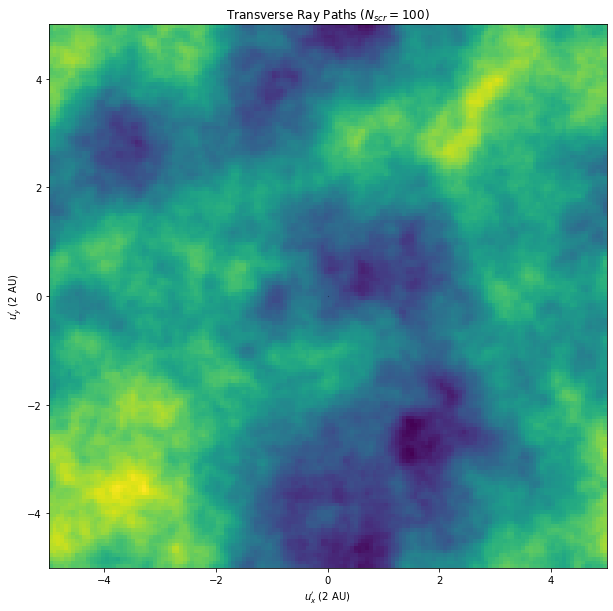

In [17]:
# Plot realization of phase screen
fig = plt.figure(figsize=(10,10))
plt.imshow(Kolmogorov(len(rx), len(ry)), extent = (-5, 5, -5, 5), aspect = 'auto')
plt.scatter(0, 0, c = 'k', s = 0.02, label = r'$\alpha$ = ' + '5/3' + '\n' + \
    '$r_{F} = 1.$' + '\n' + 'DM = 1e-5 pc cm$^{-3}$' + '\n' + '$\psi=0$' + '\n' + 'AR = 1' + '\n' + \
    'mb$_{scat}$=2' + '\n' + 'scale$_{inner}$ = $0.01 r_{F}$')
plt.title('Transverse Ray Paths ($N_{scr} = $' + str(nscreen) + ')')
plt.xlabel('$u^\prime_{x}$ (2 AU)')
plt.ylabel('$u^\prime_{y}$ (2 AU)')
#plt.legend(loc = 'upper right')
#plt.colorbar()
#plt.title('Phase Screen (Kolmogorov)')
plt.show()
fig.savefig('KolmogorovScreen.png')

In [8]:
#Video('scatterPlotAnimation_v1.mp4')

#plt.show()

# Singular plot at iscreen (user specified)
#iscreen = 490
#for iscreen in range(10, 400, 10):
#    fig = plt.figure(figsize = (15, 15))
#    plt.scatter(propsteps[iscreen][0], propsteps[iscreen][1], c = 'k', s=0.2, \
#                label = r'$\sigma$ = ' + str(sigma) + '\n' + r'$\nu = $' + '{:.2e}'.format(fmax) + \
#                ' Hz' + '\n' + 'dso = 2 kpc' + '\n' + 'dscr = dso /' + str(nscreen))
#    plt.title('Number of Gaussian Phase Screens : ' + str(iscreen))
#    plt.xlabel('$u^\prime_{x}$')
#    plt.ylabel('$u^\prime_{y}$')
#    plt.legend(loc = 'upper right')
#    plt.show()
    #fig.savefig('Gaussian_Sig' + str(sigma) + '_Scr' + str(iscreen) + '.png')

# 4x4 plot for all 4 screens
#fig = plt.figure(figsize = (15, 15))
#
#iscreen = 1
#ax1 = fig.add_subplot(221)
#plt.scatter(propsteps[iscreen][0], propsteps[iscreen][1], c = 'k', s=0.2, \
#            label = r'$\sigma$ = ' + str(sigma) + '\n' + r'$\nu = $' + '{:.2e}'.format(fmax) + \
#            ' Hz' + '\n' + 'dso = 2 kpc' + '\n' + 'dscr = dso /' + str(nscreen))
#plt.title('Number of Gaussian Phase Screens : ' + str(iscreen))
#plt.xlabel('$u^\prime_{x}$')
#plt.ylabel('$u^\prime_{y}$')
#plt.legend(loc = 'upper right')
#
#iscreen = 50
#ax2 = fig.add_subplot(222)
#plt.scatter(propsteps[iscreen][0], propsteps[iscreen][1], c = 'k', s=0.2, \
#            label = r'$\sigma$ = ' + str(sigma) + '\n' + r'$\nu = $' + '{:.2e}'.format(fmax) + \
#            ' Hz' + '\n' + 'dso = 2 kpc' + '\n' + 'dscr = dso /' + str(nscreen))
#plt.title('Number of Gaussian Phase Screens : ' + str(iscreen))
#plt.xlabel('$u^\prime_{x}$')
#plt.ylabel('$u^\prime_{y}$')
#plt.legend(loc = 'upper right')
#
#iscreen = 150
#ax3 = fig.add_subplot(223)
#plt.scatter(propsteps[iscreen][0], propsteps[iscreen][1], c = 'k', s=0.2, \
#            label = r'$\sigma$ = ' + str(sigma) + '\n' + r'$\nu = $' + '{:.2e}'.format(fmax) + \
#            ' Hz' + '\n' + 'dso = 2 kpc' + '\n' + 'dscr = dso /' + str(nscreen))
#plt.title('Number of Gaussian Phase Screens : ' + str(iscreen))
#plt.xlabel('$u^\prime_{x}$')
#plt.ylabel('$u^\prime_{y}$')
#plt.legend(loc = 'upper right')
#
#iscreen = 400
#ax4 = fig.add_subplot(224)
#plt.scatter(propsteps[iscreen][0], propsteps[iscreen][1], c = 'k', s=0.2, \
#            label = r'$\sigma$ = ' + str(sigma) + '\n' + r'$\nu = $' + '{:.2e}'.format(fmax) + \
#            ' Hz' + '\n' + 'dso = 2 kpc' + '\n' + 'dscr = dso /' + str(nscreen))
#plt.title('Number of Gaussian Phase Screens : ' + str(iscreen))
#plt.xlabel('$u^\prime_{x}$')
#plt.ylabel('$u^\prime_{y}$')
#plt.legend(loc = 'upper right')
#
#plt.show()
#fig.savefig('Gaussian_Sig' + str(sigma) + '_ScrAll' + '.png')

